## Load packages, data and functions

### Packages

In [64]:
import scipy.stats as ss
import numpy as np
import pandas as pd
import seaborn as sns
import tkinter
import matplotlib
import matplotlib.pyplot as plt

import time

from sklearn import preprocessing
import itertools

matplotlib.use('TkAgg')

### Functions

In [2]:
# plot size
def plot(dpi):
    fig, ax=plt.subplots(dpi=dpi)
    ax.plot([2,4,1,5], label="Label")
    ax.legend()

In [3]:
# função frequency report
def frequency_report(data,parameter, n):
    most_frequent = data[parameter].value_counts()
    temp = most_frequent.head(n)
    
    titulos = list(temp.index)
    counts = list(temp)
    percent = list(round(temp/sum(most_frequent)*100,2))
    zipped = list(zip(titulos,counts,percent))
    
    df_ocupation = pd.DataFrame(data = zipped, columns= ["Titulo","Count","Porcentagem (%)"])
    
    return(df_ocupation)

In [4]:
# correlation for categorical data
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [185]:
def data_to_stack(data,variables):
    agg = data.groupby(variables)['count'].sum().unstack().fillna(0)
    
    total = [[] for x in range(len(agg))]
    for i in range(len(agg)):
        total[i] = np.array(agg)[i].sum()
        
    result = [[] for x in range(len(agg))]
    matrix = np.array(agg)
    for i in range(len(agg)):
        result[i] = (matrix[i])/(total[i])
        
    output = pd.DataFrame(np.array(result), columns= list(agg.columns), 
                          index = list(agg.index))
    
    output.columns.name = agg.columns.name
    output.index.name = agg.index.name
    
    return(output)

### Data

In [25]:
# load data
path1 = '/home/caio/Documents/jupyter-workplace/data-mining-assignment/reformed_all_data.csv'
data =  pd.read_csv(path1, index_col=0)
data = data.drop(['PESO','GESTACAO'],axis =1)

path2 = '/home/caio/Documents/jupyter-workplace/data-mining-assignment/sample3000_clustered.csv'
data_cluster =  pd.read_csv(path2, index_col=0)
data_cluster = data_cluster.drop(['PESO','GESTACAO'],axis =1)

## Population description

In [ ]:
# demonstrar que a população preta e parda possuem perfis similares
# demonstrar diferenças da população preta/parda coma população branca

In [38]:
data.head(n=3)

,IDADEMAE,ESTCIVMAE,ESCMAE,RACACOR,CODOCUPMAE,CONSULTAS,MESPRENAT,IDANOMAL,parto_prematuro,APGAR
1,22,Solteira,8 a 11 anos,Parda,Técnico de planejamento de produção,Ideal,Atraso,Nao,Normal,Normal
1,27,Casada,12 e mais,Parda,Advogado,Ideal,NaN,Nao,Indicio,Normal
1,31,Casada,8 a 11 anos,Parda,Vendedor de comércio varejista,Ideal,Atraso,Nao,Normal,Normal


In [70]:
# separar
branca = data
branca = branca[branca['RACACOR'] == 'Branca']

preta = data
preta = preta[preta['RACACOR'] == 'Preta']

parda = data
parda = parda[parda['RACACOR'] == 'Parda']

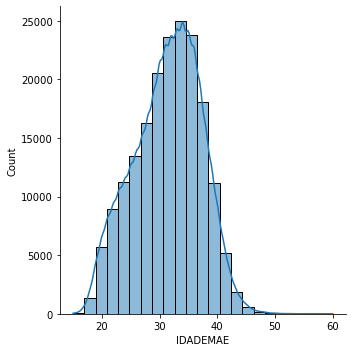

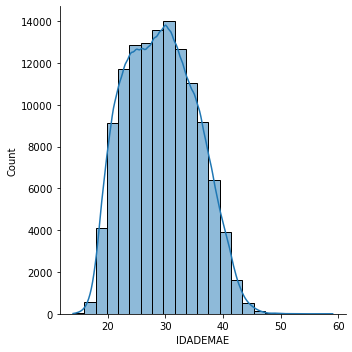

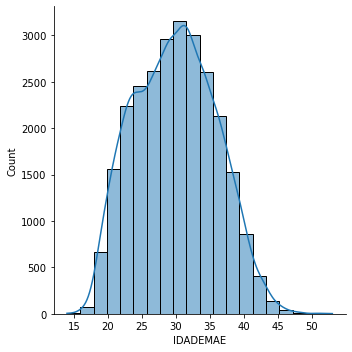

In [61]:
# distribuição das idades 
%matplotlib inline

#plt.figure(figsize = (5,5))
sns.displot(branca['IDADEMAE'], bins=23, kde=True)
sns.displot(parda['IDADEMAE'], bins=23, kde=True)
sns.displot(preta['IDADEMAE'], bins=20, kde=True)

plt.show()

In [223]:
# stacked charts (ESTCIVMAE & ESCMAE)
data_agg = data.assign(count = 1)
data_agg = data_agg[(data_agg['RACACOR'] != 'Amarela')&(data_agg['RACACOR'] != 'Indigina')]

agg_civ = data_to_stack(data_agg,['RACACOR','ESTCIVMAE'])
agg_esc = data_to_stack(data_agg,['RACACOR','ESCMAE'])

(array([0, 1, 2]),
 [Text(0, 0, 'Branca'), Text(1, 0, 'Parda'), Text(2, 0, 'Preta')])

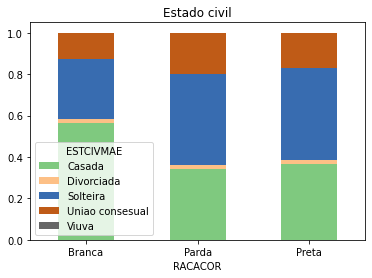

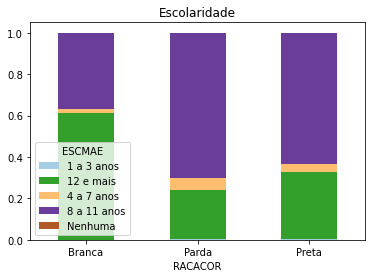

In [224]:
agg_civ.plot(kind='bar', stacked=True, colormap='Accent')
plt.title('Estado civil')
plt.xticks(rotation=0, ha='center')

agg_esc.plot(kind='bar', stacked=True, colormap = 'Paired')
plt.title('Escolaridade')
plt.xticks(rotation=0, ha='center')

## Cluster description

* Stacked bar chart - para raça, ocupação e escolaridade de cada cluster

In [218]:
data_cluster_modified = data_cluster
# juntar cluster 1, 2 e 3 
data_cluster_modified['cluster'] = data_cluster_modified['cluster'].map({0:0,1:1,2:1,3:1}) 

In [219]:
agg = data_cluster_modified.assign(count = 1)
agg = agg.rename(columns={'cluster': 'Cluster'})
agg = agg.rename(columns={'RACACOR': 'Raça'})
agg = agg.rename(columns={'CODOCUPMAE': 'Ocupação'})
agg = agg.rename(columns={'ESCMAE': 'Escolaridade'})

ocupation_dtype = pd.CategoricalDtype(categories=['Empregado doméstico',
                                                  'Operador de caixa',
                                                  'Vendedor de comércio varejista',
                                                  'Advogado',
                                                  'Enfermeiro',
                                                  'Psicólogo clínico'], ordered=True)
agg['Ocupação'].astype(ocupation_dtype)

agg_rac = data_to_stack(agg,['Cluster','Raça'])
agg_ocu = data_to_stack(agg,['Cluster','Ocupação'])
agg_esc = data_to_stack(agg,['Cluster','Escolaridade'])

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

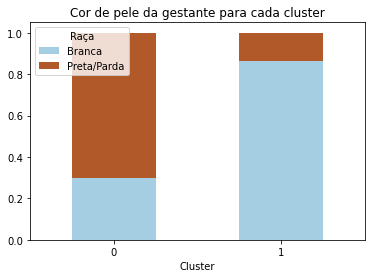

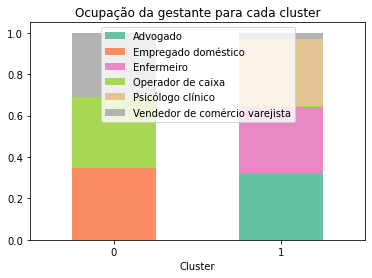

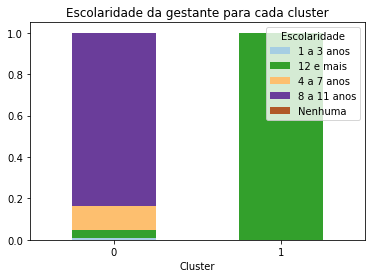

In [216]:
%matplotlib inline

agg_rac.plot(kind='bar', stacked=True, colormap='Paired')
plt.title('Cor de pele da gestante para cada cluster')
plt.xticks(rotation=0, ha='center')

agg_ocu.plot(kind='bar', stacked=True, colormap = 'Set2',figsize=(6,4)).legend(loc='upper center')
plt.title('Ocupação da gestante para cada cluster')
plt.xticks(rotation=0, ha='center')

agg_esc.plot(kind='bar', stacked=True, colormap = 'Paired')
plt.title('Escolaridade da gestante para cada cluster')
plt.xticks(rotation=0, ha='center')



In [220]:
agg = agg.rename(columns={'parto_prematuro': 'Prematuridade'})
agg = agg.rename(columns={'CONSULTAS': 'Nª de consultas prenatal'})
agg = agg.rename(columns={'MESPRENAT': 'Inicio do prenatal'})


agg_apgar = data_to_stack(agg,['Cluster','APGAR'])
agg_prema = data_to_stack(agg,['Cluster','Prematuridade'])
agg_consult = data_to_stack(agg,['Cluster','Nª de consultas prenatal'])
agg_mespren = data_to_stack(agg,['Cluster','Inicio do prenatal'])

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

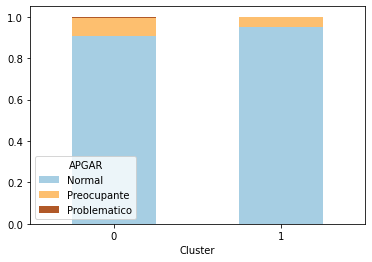

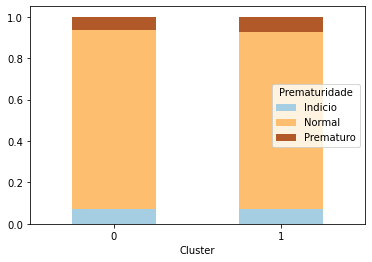

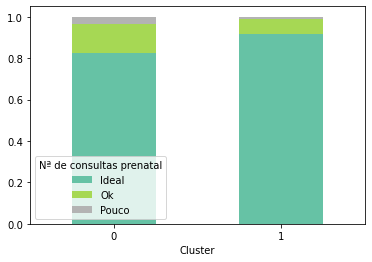

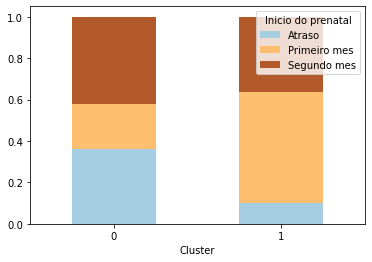

In [221]:
agg_apgar.plot(kind='bar', stacked=True, colormap='Paired')
plt.title('')
plt.xticks(rotation=0, ha='center')

agg_prema.plot(kind='bar', stacked=True, colormap='Paired')
plt.title('')
plt.xticks(rotation=0, ha='center')

agg_consult.plot(kind='bar', stacked=True, colormap = 'Set2')
plt.title('')
plt.xticks(rotation=0, ha='center')

agg_mespren.plot(kind='bar', stacked=True, colormap = 'Paired')
plt.title('')
plt.xticks(rotation=0, ha='center')

### Cluster 0

In [33]:
cluster_0 = data_cluster[data_cluster['cluster'] == 0]

description1 = cluster_0['APGAR'].value_counts()
description2 = cluster_0['parto_prematuro'].value_counts()
description3 = cluster_0['CONSULTAS'].value_counts()
description4 = cluster_0['MESPRENAT'].value_counts()

print("APGAR: \n\n",description1)
print("\nPrematuridade: \n\n",description2)
print("\nNumero de consultas no prenatal: \n\n",description3)
print("\nInicio do acompanhamento prenatal: \n\n",description4)

APGAR: 

 Normal          1309
Preocupante      122
Problematico      11
Name: APGAR, dtype: int64

Prematuridade: 

 Normal       1241
Indicio       106
Prematuro      95
Name: parto_prematuro, dtype: int64

Numero de consultas no prenatal: 

 Ideal    1189
Ok        202
Pouco      51
Name: CONSULTAS, dtype: int64

Inicio do acompanhamento prenatal: 

 Segundo mes     604
Atraso          519
Primeiro mes    311
Name: MESPRENAT, dtype: int64


### Cluster 1

In [34]:
cluster_1 = data_cluster[data_cluster['cluster'] == 1]

description1 = cluster_1['APGAR'].value_counts()
description2 = cluster_1['parto_prematuro'].value_counts()
description3 = cluster_1['CONSULTAS'].value_counts()
description4 = cluster_1['MESPRENAT'].value_counts()

print("APGAR: \n\n",description1)
print("\nPrematuridade: \n\n",description2)
print("\nNumero de consultas no prenatal: \n\n",description3)
print("\nInicio do acompanhamento prenatal: \n\n",description4)

APGAR: 

 Normal          537
Preocupante      22
Problematico      3
Name: APGAR, dtype: int64

Prematuridade: 

 Normal       471
Prematuro     54
Indicio       37
Name: parto_prematuro, dtype: int64

Numero de consultas no prenatal: 

 Ideal    514
Ok        40
Pouco      8
Name: CONSULTAS, dtype: int64

Inicio do acompanhamento prenatal: 

 Primeiro mes    339
Segundo mes     173
Atraso           50
Name: MESPRENAT, dtype: int64


### Cluster 2

In [36]:
cluster_2 = data_cluster[data_cluster['cluster'] == 2]

description1 = cluster_2['APGAR'].value_counts()
description2 = cluster_2['parto_prematuro'].value_counts()
description3 = cluster_2['CONSULTAS'].value_counts()
description4 = cluster_2['MESPRENAT'].value_counts()

print("APGAR: \n\n",description1)
print("\nPrematuridade: \n\n",description2)
print("\nNumero de consultas no prenatal: \n\n",description3)
print("\nInicio do acompanhamento prenatal: \n\n",description4)

APGAR: 

 Normal          465
Preocupante      30
Problematico      1
Name: APGAR, dtype: int64

Prematuridade: 

 Normal       427
Indicio       40
Prematuro     29
Name: parto_prematuro, dtype: int64

Numero de consultas no prenatal: 

 Ideal    438
Ok        54
Pouco      4
Name: CONSULTAS, dtype: int64

Inicio do acompanhamento prenatal: 

 Segundo mes     211
Primeiro mes    206
Atraso           79
Name: MESPRENAT, dtype: int64


### Cluster 3

In [35]:
cluster_3 = data_cluster[data_cluster['cluster'] == 3]

description1 = cluster_3['APGAR'].value_counts()
description2 = cluster_3['parto_prematuro'].value_counts()
description3 = cluster_3['CONSULTAS'].value_counts()
description4 = cluster_3['MESPRENAT'].value_counts()

print("APGAR: \n\n",description1)
print("\nPrematuridade: \n\n",description2)
print("\nNumero de consultas no prenatal: \n\n",description3)
print("\nInicio do acompanhamento prenatal: \n\n",description4)

APGAR: 

 Normal          481
Preocupante      18
Problematico      1
Name: APGAR, dtype: int64

Prematuridade: 

 Normal       429
Indicio       36
Prematuro     35
Name: parto_prematuro, dtype: int64

Numero de consultas no prenatal: 

 Ideal    474
Ok        21
Pouco      5
Name: CONSULTAS, dtype: int64

Inicio do acompanhamento prenatal: 

 Primeiro mes    290
Segundo mes     179
Atraso           31
Name: MESPRENAT, dtype: int64


## Variable association

Cramér’s V nominal association test

In [ ]:
data_cluster['cluster'].value_counts()

In [225]:
cols = ['cluster',"RACACOR", "CODOCUPMAE", "ESCMAE","MESPRENAT","CONSULTAS","parto_prematuro","APGAR",'IDANOMAL']
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(data_cluster[col1], data_cluster[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

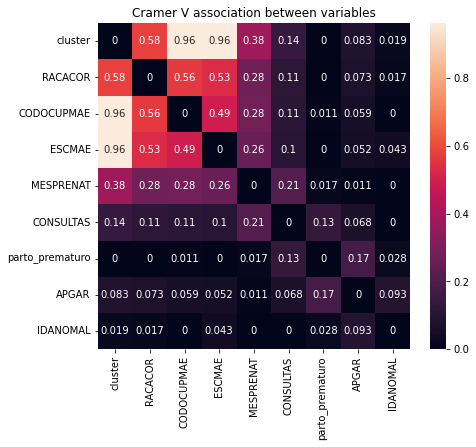

In [226]:
corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V association between variables")
ax

plt.show()

In [ ]:
corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V association between variables")
ax

plt.show()